In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/planets-dataset/planet/planet/sample_submission.csv
/kaggle/input/planets-dataset/planet/planet/train_classes.csv
/kaggle/input/planets-dataset/planet/planet/test-jpg/test_39140.jpg
/kaggle/input/planets-dataset/planet/planet/test-jpg/test_4849.jpg
/kaggle/input/planets-dataset/planet/planet/test-jpg/test_18979.jpg
/kaggle/input/planets-dataset/planet/planet/test-jpg/test_24790.jpg
/kaggle/input/planets-dataset/planet/planet/test-jpg/test_30624.jpg
/kaggle/input/planets-dataset/planet/planet/test-jpg/test_7922.jpg
/kaggle/input/planets-dataset/planet/planet/test-jpg/test_33905.jpg
/kaggle/input/planets-dataset/planet/planet/test-jpg/test_15492.jpg
/kaggle/input/planets-dataset/planet/planet/test-jpg/test_16642.jpg
/kaggle/input/planets-dataset/planet/planet/test-jpg/test_37288.jpg
/kaggle/input/planets-dataset/planet/planet/test-jpg/test_9357.jpg
/kaggle/input/planets-dataset/planet/planet/test-jpg/test_40104.jpg
/kaggle/input/planets-dataset/planet/planet/test-jpg/test_1

In [3]:
import tensorflow as tf
print(tf.__version__)


2.6.4


In [4]:
import sys
import os
import subprocess

# Make sure you have all of these packages installed, e.g. via pip
import numpy as np
import pandas as pd
import seaborn as sns
import rasterio
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy
from scipy import ndimage
from IPython.display import display
%matplotlib inline
%reload_ext autoreload
%autoreload 2


In [6]:
from fastai.vision import *

In [7]:
!ls ../input/planets-dataset/planet/planet/train-jpg | wc -l

40479


In [10]:
!ls ../input/planets-dataset/planet/planet/test-jpg | wc -l

40669


In [11]:
# Libraries for Loading and Preparing dataset
from os import listdir
from numpy import zeros
from numpy import asarray
from numpy import savez_compressed
from pandas import read_csv
from tensorflow.keras import backend
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
import os
import time
from sklearn.metrics import fbeta_score
import tensorflow as tf
from tensorflow.keras.optimizers import SGD
import sys

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Conv2D, MaxPooling2D,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

In [13]:
import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib.image import imread
%matplotlib inline

In [14]:
# Imporing Required Libraries
import pandas as pd
import numpy as np

In [16]:
data_path = "../input/planets-dataset/planet/planet"
train_dataset = pd.read_csv(data_path+"/train_classes.csv")
test_image_dataset = data_path + "/test-jpg/"
train_image_dataset = data_path + "/train-jpg/"

In [17]:
train_dataset.head()

image_name                                       tags
0    train_0                               haze primary
1    train_1            agriculture clear primary water
2    train_2                              clear primary
3    train_3                              clear primary
4    train_4  agriculture clear habitation primary road

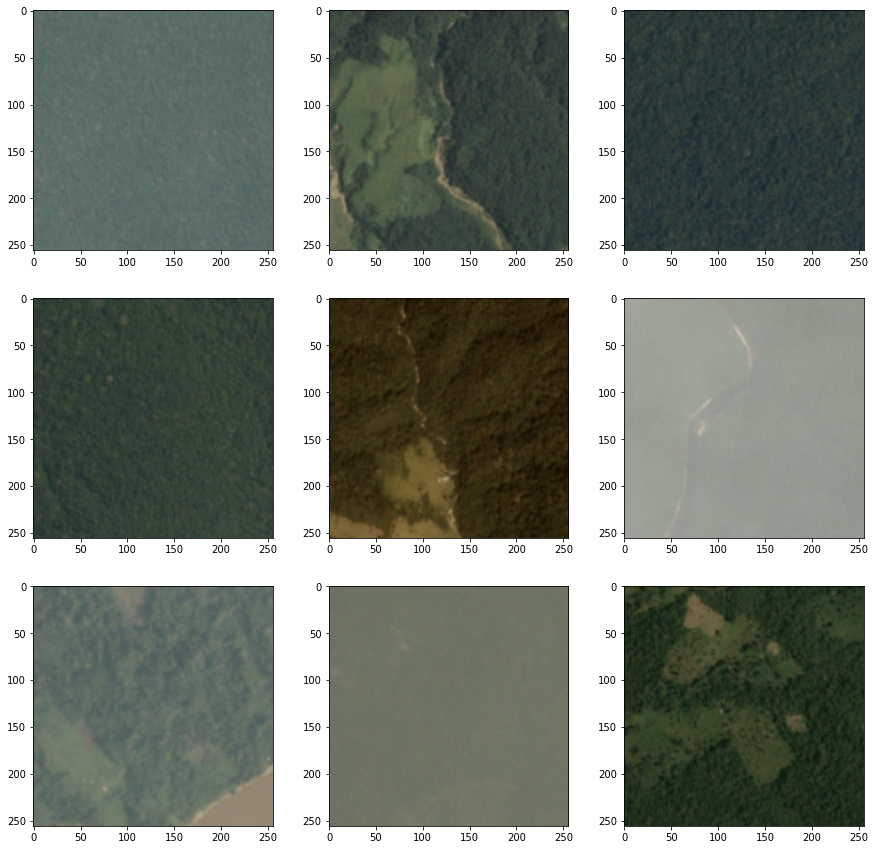

In [18]:
#View train Images
plt.figure(figsize=(15,15))
folder = data_path + "/train-jpg/"
for i in range(9):
    pyplot.subplot(330 + 1 + i)
    
    #Defining the file
    file = train_image_dataset + 'train_' + str(i) + '.jpg'
    
    #Load pixels of the images
    images = imread(file)
    
    #Plot the pixel images data
    pyplot.imshow(images)
    
plt.show()

In [19]:
# Removal of tags separated with a space, by splitting the spaces in the train_dataset
dataset_list = []
for tag in train_dataset.tags.values:
    dataset = tag.split(' ')
    for data in dataset:
        if data not in dataset_list:
            dataset_list.append(data)
            
len(dataset_list)

17

In [20]:
dataset_list.sort()

In [21]:
#Creating a tag dataset map
tag_mappings = {dataset_list[i]: i for i in range(len(dataset_list))}
tag_mappings

{'agriculture': 0,
 'artisinal_mine': 1,
 'bare_ground': 2,
 'blooming': 3,
 'blow_down': 4,
 'clear': 5,
 'cloudy': 6,
 'conventional_mine': 7,
 'cultivation': 8,
 'habitation': 9,
 'haze': 10,
 'partly_cloudy': 11,
 'primary': 12,
 'road': 13,
 'selective_logging': 14,
 'slash_burn': 15,
 'water': 16}

In [22]:
#Creating a tag dataset map
inverse_datasets_map = {i:dataset_list[i] for i in range(len(dataset_list))}
inverse_datasets_map

{0: 'agriculture',
 1: 'artisinal_mine',
 2: 'bare_ground',
 3: 'blooming',
 4: 'blow_down',
 5: 'clear',
 6: 'cloudy',
 7: 'conventional_mine',
 8: 'cultivation',
 9: 'habitation',
 10: 'haze',
 11: 'partly_cloudy',
 12: 'primary',
 13: 'road',
 14: 'selective_logging',
 15: 'slash_burn',
 16: 'water'}

In [23]:
# Map files to tags
def file_mapper(data_csv):
    mapper = dict()
    for i in range(len(data_csv)):
        name, tags = data_csv['image_name'][i], data_csv['tags'][i]
        mapper[name] = tags.split(' ')
    return mapper
    
mapped_file = file_mapper(train_dataset)
#mapped_file

In [25]:
#Create a one hot encoding for the tags
def one_hot_encoder(tags, mapper):
    
    #Creating an empty matrix(Vector)
    encoding = np.zeros(len(mapper), dtype='uint8')
    
    #Map 1 for each tag in the vector created
    for t in tags:
        encoding[mapper[t]] = 1
    return encoding

In [26]:
#Preparation of the image data
def load_dataset(path, file_mapping, tag_mapping):
    photos = list()
    targets = list()
    
    #For files in the image directory
    for file in os.listdir(train_image_dataset):
        
        #Load Images
        photo = load_img(path + file, target_size = (64, 64))
        
        #Converting photos to numpy array
        photo = img_to_array(photo, dtype = 'uint8')
        
        #Tags
        tags = mapped_file[file[:-4]]
        
        #OHE of Tags
        target = one_hot_encoder(tags, tag_mapping)
        
        #Stores
        photos.append(photo)
        targets.append(target)
    X = np.asarray(photos,dtype='uint8')
    Y = np.asarray(targets,dtype='uint8')
    return X,Y

X, Y = load_dataset(train_image_dataset, mapped_file, tag_mappings)
print(X.shape, Y.shape)

# Compressing X and Y arrays into one single file
np.savez_compressed('planet_data.npz', X, Y)

(40479, 64, 64, 3) (40479, 17)


In [27]:
#Loading the Dataset
dataset = np.load('./planet_data.npz')
X, Y = dataset['arr_0'], dataset['arr_1']
print(X.shape)
print(Y.shape)

(40479, 64, 64, 3)
(40479, 17)


In [28]:
from sklearn.model_selection import train_test_split
#Split Into training and Validation set
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size = 0.3, random_state = 123)
print("X_train shape : ", X_train.shape)
print("y_train shape : ", y_train.shape)
print("X_val shape", X_val.shape)
print("y_val shape : ", y_val.shape)

X_train shape :  (28335, 64, 64, 3)
y_train shape :  (28335, 17)
X_val shape (12144, 64, 64, 3)
y_val shape :  (12144, 17)


In [30]:
# test f-beta score
from numpy import load
from numpy import ones
from numpy import asarray
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score

In [31]:
train_yhat = asarray([ones(y_train.shape[1]) for _ in range(y_train.shape[0])])
val_yhat = asarray([ones(y_val.shape[1]) for _ in range(y_val.shape[0])])

#Evaluate Predictions
train_score = fbeta_score(y_train, train_yhat, average='samples', beta=2)
test_score = fbeta_score(y_val, val_yhat, average='samples', beta=2)

print('All Ones: train=%.3f, test=%.3f' % (train_score, test_score))

All Ones: train=0.483, test=0.485


In [32]:
from tensorflow.keras import backend

#Calculating fbeta for multi-class/label classification
def fbeta(y_true, y_pred, beta=2):
    y_pred = backend.clip(y_pred, 0, 1)
    #Calculate TP, FP and FN
    tp = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)), axis=1)
    fp = backend.sum(backend.round(backend.clip(y_pred - y_true, 0, 1)), axis=1)
    fn = backend.sum(backend.round(backend.clip(y_true - y_pred, 0, 1)), axis=1)
    
    #Calculate Precision
    p = tp / (tp + fp + backend.epsilon())
    
    #Calculae Recall
    r = tp / (tp + fn + backend.epsilon())
    
    #Calculate fbeta, averaged across each class
    bb = beta ** 2
    fbeta_score = backend.mean((1 + bb)* (p * r)/ (bb * p + r + backend.epsilon()))
    return fbeta_score

In [33]:
#Evaluate predictions with keras
train_score = fbeta(backend.variable(y_train), backend.variable(train_yhat))
test_score = fbeta(backend.variable(y_val), backend.variable(val_yhat))

print('All Ones (keras): train=%.3f, test=%.3f' % (train_score, test_score))

2022-09-20 17:26:39.189378: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-20 17:26:39.330352: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-20 17:26:39.334638: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-20 17:26:39.339637: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

All Ones (keras): train=0.483, test=0.485


In [35]:
model = Sequential()
#A convolution is used to extract features such as colors edges orientation from input images
#The Activation function introduces non linearity
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(64, 64, 3)))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
#Pooling layer carrie out dimensionality reduction (Downsampling)
#Reduces Overfitting, Increases training speed
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3,3), activation='relu', kernel_initializer='he_uniform', padding ='same'))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3,3), activation='relu', kernel_initializer='he_uniform', padding ='same'))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))

#Max pooling gives a feature map
#Flattening is converting the data into a 1-dimensional array for inputting it to the next layer.(Feature Vector)
#Dense layer expects a 1 Dimension array
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(17, activation='sigmoid'))

#Compile Model
opt = SGD(learning_rate=0.01, momentum=0.9)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[fbeta])

In [36]:
#Create a data Generator
datagen = ImageDataGenerator(rescale=1.0/255.0)
#Prepare Iterators
train_it = datagen.flow(X_train, y_train, batch_size = 128)
test_it = datagen.flow(X_val, y_val, batch_size=128)

In [37]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 128)      

In [38]:
#fit model
#The fit_generator() function called to fit the model returns a dictionary containing the loss and F-beta scores recorded each epoch on the train and test dataset.
history = model.fit(train_it, steps_per_epoch=len(train_it), validation_data=test_it, validation_steps=len(test_it), epochs=20, verbose=1)

2022-09-20 17:30:32.491714: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-09-20 17:30:34.735963: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


222/222 [==============================] - 16s 31ms/step - loss: 0.2488 - fbeta: 0.6234 - val_loss: 0.2182 - val_fbeta: 0.6442
Epoch 2/20
222/222 [==============================] - 7s 31ms/step - loss: 0.2124 - fbeta: 0.6763 - val_loss: 0.2022 - val_fbeta: 0.6919
Epoch 3/20
222/222 [==============================] - 7s 30ms/step - loss: 0.2033 - fbeta: 0.7036 - val_loss: 0.1963 - val_fbeta: 0.7460
Epoch 4/20
222/222 [==============================] - 6s 28ms/step - loss: 0.1936 - fbeta: 0.7294 - val_loss: 0.1894 - val_fbeta: 0.7217
Epoch 5/20
222/222 [==============================] - 6s 29ms/step - loss: 0.1875 - fbeta: 0.7442 - val_loss: 0.1827 - val_fbeta: 0.7551
Epoch 6/20
222/222 [==============================] - 6s 28ms/step - loss: 0.1806 - fbeta: 0.7555 - val_loss: 0.1745 - val_fbeta: 0.7588
Epoch 7/20
222/222 [==============================] - 7s 31ms/step - loss: 0.1753 - fbeta: 0.7645 - val_loss: 0.1702 - val_fbeta: 0.7758
Epoch 8/20
222/222 [==============================]

In [39]:
file = train_image_dataset + 'train_' + str(0) + '.jpg'
file

'../input/planets-dataset/planet/planet/train-jpg/train_0.jpg'

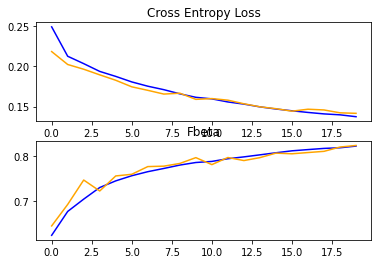

In [40]:
#Plot diagnostic learning curves
def summarize_diagnistics(history):
    #Plot loss
    pyplot.subplot(211)
    pyplot.title("Cross Entropy Loss")
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='orange', label='test')
    
    #Plot accuracy
    pyplot.subplot(212)
    pyplot.title('Fbeta')
    pyplot.plot(history.history['fbeta'], color='blue', label='train')
    pyplot.plot(history.history['val_fbeta'], color = 'orange', label='test')
    
    #Save plot to file
    filename = sys.argv[0].split('/')[-1]
    pyplot.savefig(filename + '_plot.png')
    #pyplot.close()
    pyplot.show()
    
summarize_diagnistics(history)

In [43]:
#function to prepare the image for prediction
def load_image(filename):
    # load the image
    img = load_img(filename, target_size=(64, 64))
    # convert to array
    img = img_to_array(img)
    # reshape into a single sample with 3 channels
    img = img.reshape(1, 64, 64, 3)
    # center pixel data
    img = np.asarray(img,dtype='uint8')
    img = img - [123.68, 116.779, 103.939]
    return img

In [44]:
file = train_image_dataset + 'train_' + str(0) + '.jpg'
file

'../input/planets-dataset/planet/planet/train-jpg/train_0.jpg'

In [45]:
img = load_image(file)
result = model.predict(img)
result
result.round()

array([[1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0.,
        0.]], dtype=float32)

In [48]:
def run_example(inv_mapping):
    # load the image
    img = load_image(file)
    # load model
    # predict the class
    result = model.predict(img)
    print(result[0])
    # map prediction to tags
    tags = prediction_to_tags(inv_mapping, result[0])
    print(tags)

In [50]:
def prediction_to_tags(inv_mapping, prediction):
    # round probabilities to {0, 1}
    values = prediction.round()
    # collect all predicted tags
    tags = [inv_mapping[i] for i in range(len(values)) if values[i] == 1.0]
    return tags

In [51]:
def create_tag_mapping(train_dataset):
    # create a set of all known tags
    labels = set()
    for i in range(len(train_dataset)):
        # convert spaced separated tags into an array of tags
        tags = train_dataset['tags'][i].split(' ')
        # add tags to the set of known labels
        labels.update(tags)
    # convert set of labels to a list to list
    labels = list(labels)
    # order set alphabetically
    labels.sort()
    # dict that maps labels to integers, and the reverse
    labels_map = {labels[i]:i for i in range(len(labels))}
    inv_labels_map = {i:labels[i] for i in range(len(labels))}
    return labels_map, inv_labels_map
_, inv_mapping = create_tag_mapping(train_dataset)
run_example(inv_mapping)

[0.9999982 0.        0.        0.        0.        1.        0.
 0.        0.        1.        0.        0.        1.        1.
 0.        0.        0.       ]
['agriculture', 'clear', 'habitation', 'primary', 'road']


In [52]:
#saving the model
import os.path
if os.path.isfile('planet_model.h5') is False:
    model.save('planet_model.h5')

In [54]:
dependencies = {
     'fbeta': fbeta
}

In [55]:
from tensorflow.keras.models import load_model
model = load_model('planet_model.h5', custom_objects=dependencies)

In [56]:
#printing the weights of the model
model.get_weights()

[array([[[[ 4.52234209e-01, -7.83364922e-02,  4.08047080e-01,
           -3.69917721e-01, -2.42805198e-01, -4.55005407e-01,
           -3.41947436e-01, -2.05679536e-01, -2.14033812e-01,
            1.66860387e-01,  2.80105263e-01, -3.12165976e-01,
           -2.95170635e-01, -1.13082215e-01,  2.23066866e-01,
           -4.67390805e-01,  4.10546988e-01,  4.95053738e-01,
            9.77368653e-02,  4.68462855e-01, -2.92915642e-01,
            3.09073001e-01, -1.56071112e-01,  4.31824803e-01,
           -3.85831445e-01, -5.52778430e-02,  3.81143183e-01,
           -1.48445576e-01, -2.28364974e-01,  3.13464105e-01,
           -2.96174347e-01, -5.01337741e-03],
          [ 2.11056657e-02,  2.84548461e-01, -2.51766145e-01,
            3.71979326e-01, -3.00094277e-01, -3.29821169e-01,
           -1.49035349e-01,  1.15765937e-01,  3.56927395e-01,
           -5.35699129e-01,  2.42324173e-02,  4.34807420e-01,
           -7.39365295e-02,  2.91327327e-01, -6.33495823e-02,
            3.34852010e-

In [57]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 128)      

In [65]:
predictions = []

In [66]:
len(listdir(data_path + "/train-jpg/"))

40479

In [67]:
len(listdir(data_path + "/test-jpg/"))

40669

In [68]:
listdir(data_path + "/test-jpg/")[1]

'test_4849.jpg'

In [69]:
" ".join(['partly_cloudy', 'primary'])

'partly_cloudy primary'

In [70]:
listdir(data_path + "/test-jpg/")[i]

'test_16642.jpg'

In [71]:
(data_path + "/test-jpg/") + listdir(data_path + "/test-jpg/")[0]

'../input/planets-dataset/planet/planet/test-jpg/test_39140.jpg'

In [72]:
for i in range(len(listdir(data_path + "/test-jpg/"))):
    img = load_image((data_path + "/test-jpg/") + listdir(data_path + "/test-jpg/")[i])
    pred = model.predict(img)
    tags = prediction_to_tags(inv_mapping, pred[0])
    predictions.append(" ".join(tags))

In [73]:
predictions

['agriculture clear habitation primary road',
 'agriculture clear habitation primary road',
 'clear habitation road',
 'artisinal_mine clear primary',
 'agriculture clear habitation road',
 'agriculture clear habitation road',
 'agriculture clear habitation road',
 'agriculture clear habitation primary road',
 'agriculture clear habitation primary road',
 'agriculture clear habitation road',
 'agriculture clear habitation primary road',
 'artisinal_mine clear habitation primary road',
 'clear habitation primary road',
 'agriculture habitation partly_cloudy primary',
 'clear habitation road',
 'primary',
 'agriculture clear habitation road',
 'artisinal_mine clear primary road',
 'agriculture clear habitation road',
 'agriculture clear habitation primary road',
 'clear habitation road',
 'agriculture clear habitation road',
 'cloudy primary',
 'agriculture clear habitation road',
 'agriculture bare_ground habitation primary road',
 'agriculture clear habitation road',
 'agriculture habi

In [74]:
(predictions[0])

'agriculture clear habitation primary road'

In [77]:
df = pd.DataFrame()
df['tags'] = predictions

In [78]:
df.head(20)

tags
0      agriculture clear habitation primary road
1      agriculture clear habitation primary road
2                          clear habitation road
3                   artisinal_mine clear primary
4              agriculture clear habitation road
5              agriculture clear habitation road
6              agriculture clear habitation road
7      agriculture clear habitation primary road
8      agriculture clear habitation primary road
9              agriculture clear habitation road
10     agriculture clear habitation primary road
11  artisinal_mine clear habitation primary road
12                 clear habitation primary road
13  agriculture habitation partly_cloudy primary
14                         clear habitation road
15                                       primary
16             agriculture clear habitation road
17             artisinal_mine clear primary road
18             agriculture clear habitation road
19     agriculture clear habitation primary road

In [79]:
df.isnull().sum()


tags    0
dtype: int64

In [80]:
df.shape

(40669, 1)

In [81]:
len(listdir(data_path + "/test-jpg/"))

40669

In [82]:
df['image_name'] = listdir(data_path + "/test-jpg/")

df

tags      image_name
0      agriculture clear habitation primary road  test_39140.jpg
1      agriculture clear habitation primary road   test_4849.jpg
2                          clear habitation road  test_18979.jpg
3                   artisinal_mine clear primary  test_24790.jpg
4              agriculture clear habitation road  test_30624.jpg
...                                          ...             ...
40664          artisinal_mine clear primary road  test_18830.jpg
40665                      clear habitation road  test_16161.jpg
40666               artisinal_mine clear primary  test_28240.jpg
40667          agriculture clear habitation road    test_880.jpg
40668         artisinal_mine clear primary water   test_5484.jpg

[40669 rows x 2 columns]

In [84]:
submissions = pd.DataFrame()
submissions['image_name'] = listdir(data_path + "/test-jpg/")
submissions['tags'] = predictions
submissions

image_name                                       tags
0      test_39140.jpg  agriculture clear habitation primary road
1       test_4849.jpg  agriculture clear habitation primary road
2      test_18979.jpg                      clear habitation road
3      test_24790.jpg               artisinal_mine clear primary
4      test_30624.jpg          agriculture clear habitation road
...               ...                                        ...
40664  test_18830.jpg          artisinal_mine clear primary road
40665  test_16161.jpg                      clear habitation road
40666  test_28240.jpg               artisinal_mine clear primary
40667    test_880.jpg          agriculture clear habitation road
40668   test_5484.jpg         artisinal_mine clear primary water

[40669 rows x 2 columns]

In [90]:
submissions.to_csv('planet_submission.csv',index=False)